# Imports & Downloads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
stop_words = stopwords.words()

# Loading the data

In [4]:
col_names = ['thread', 'topic', "sentiment", "tweet"]
df_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\twitter_training.csv",
                     names=col_names, index_col=0, encoding="utf-8")
df_raw = df_raw.reset_index()

In [5]:
df_raw.head()

,thread,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Save val data

In [6]:
train_df = df_raw.sample(frac = 0.8)
train_df.shape

(59746, 4)

In [7]:
val_df = df_raw.drop(train_df.index)
val_df.shape

(14936, 4)

In [8]:
filepath = Path('data/twitter_validation_new.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [9]:
val_df.to_csv(filepath)

# Preparing the data

In [10]:
df = train_df

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59746 entries, 69081 to 4666
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   thread     59746 non-null  int64 
 1   topic      59746 non-null  object
 2   sentiment  59746 non-null  object
 3   tweet      59183 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## Duplicate-Check

In [12]:
df.duplicated().sum()

1823

=> bei der Menge an Daten (ca. 75k) sollten die Duplikate entfernt werden

In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## Null-Check

In [14]:
df.isna().sum()

thread         0
topic          0
sentiment      0
tweet        297
dtype: int64

=> es fehlen nur Einträge bei Tweet, dabei handelt es sich aber um das entscheidende Feature; ohne Tweet ist der Eintrag wertlos, daher droppen

In [15]:
df.dropna(axis="rows", inplace=True)
df.isna().sum()

C:\Users\admin\AppData\Local\Temp\ipykernel_372\2294936447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis="rows", inplace=True)


thread       0
topic        0
sentiment    0
tweet        0
dtype: int64

## Inconsistent text & typos

In [16]:
print('Column: Topic')
print(df['topic'].value_counts().sort_index())

Column: Topic
Amazon                               1794
ApexLegends                          1854
AssassinsCreed                       1723
Battlefield                          1770
Borderlands                          1789
CS-GO                                1744
CallOfDuty                           1830
CallOfDutyBlackopsColdWar            1817
Cyberpunk2077                        1760
Dota2                                1796
FIFA                                 1795
Facebook                             1840
Fortnite                             1775
Google                               1769
GrandTheftAuto(GTA)                  1770
Hearthstone                          1804
HomeDepot                            1785
LeagueOfLegends                      1850
MaddenNFL                            1851
Microsoft                            1856
NBA2K                                1870
Nvidia                               1793
Overwatch                            1809
PlayStation5(PS5)   

=> keine Typos erkennbar
=> Doppelung von CallOfDuty / CallOfDutyBlackopsColdWar -> ggf. zusammenlegen

In [17]:
df[(df.topic == "CallOfDuty")]

,thread,topic,sentiment,tweet
55443,2319,CallOfDuty,Positive,Hopping on the . . Uzi is pretty good. Fortun...
54410,2146,CallOfDuty,Irrelevant,@ ROKKR snatched a big win today on. est.com /...
54488,2159,CallOfDuty,Positive,You can also see @ CfDuty on board pic.gl / dG...
55000,2244,CallOfDuty,Positive,Thank God GOD
55343,2302,CallOfDuty,Positive,You
...,...,...,...,...
55768,2373,CallOfDuty,Neutral,Won just yet another tourney yesterday! That T...
55887,2393,CallOfDuty,Irrelevant,I do love me some more.
54093,2093,CallOfDuty,Positive,I'm just down here grinding the absolute balls...
55926,2400,CallOfDuty,Negative,FIX YOUR GOD DAMN SERVERS YOU NEANDERTHALS @Ca...


In [18]:
blackops_keywords = "ops|Ops"
df[(df.topic == "CallOfDuty") & (df.tweet.str.contains(blackops_keywords))]

,thread,topic,sentiment,tweet
55374,2308,CallOfDuty,Irrelevant,I love when they keep chat open for a second a...
53854,2053,CallOfDuty,Irrelevant,cops pretending about they're playing live cal...
54458,2154,CallOfDuty,Irrelevant,Ronald Reagan sends you to do absolutely nothi...
54459,2154,CallOfDuty,Irrelevant,Ronald Reagan sends you to do absolutely nothi...
53589,2009,CallOfDuty,Neutral,If anyone knows me i was literally a god at fo...
55375,2308,CallOfDuty,Irrelevant,I love it when they talk for a second after I ...
54663,2188,CallOfDuty,Neutral,@CallofDuty Can you also change the code H WAR...
53559,2004,CallOfDuty,Positive,Have any of our played Call of Duty Black Ops ...
54360,2138,CallOfDuty,Positive,I just played black ops 3 and omg. It's sooooo...
54365,2138,CallOfDuty,Positive,I just played black ops 3 and omg. It's sooooo...


In [19]:
df[(df.topic == "CallOfDutyBlackopsColdWar")]

,thread,topic,sentiment,tweet
3785,1854,CallOfDutyBlackopsColdWar,Neutral,Black Ops Gang War Reveals Fireteam Dirty Bomb...
3556,1815,CallOfDutyBlackopsColdWar,Irrelevant,Pubs are becoming actually fun for the now fir...
4194,1923,CallOfDutyBlackopsColdWar,Negative,Black Ops Cold War is definitely a step down f...
4524,1978,CallOfDutyBlackopsColdWar,Negative,I thought the graphics will be like the one in...
2791,1685,CallOfDutyBlackopsColdWar,Negative,Sweet! More recycled content! Nothing excites ...
...,...,...,...,...
3750,1849,CallOfDutyBlackopsColdWar,Positive,This would be an awesome birthday girft for @L...
4376,1953,CallOfDutyBlackopsColdWar,Irrelevant,I don't like the idea of knocking people down ...
2680,1666,CallOfDutyBlackopsColdWar,Positive,and LOVING THE CALL OF DUTY: BLACK OPS COLD WA...
4471,1969,CallOfDutyBlackopsColdWar,Irrelevant,Really excited for this team.


In [20]:
cod_keywords = "verdansk|Verdansk|warzone|Warzone|modern|Modern|warfare|Warfare"
df[(df.topic == "CallOfDutyBlackopsColdWar") & (df.tweet.str.contains(cod_keywords))]

,thread,topic,sentiment,tweet
4194,1923,CallOfDutyBlackopsColdWar,Negative,Black Ops Cold War is definitely a step down f...
2463,1630,CallOfDutyBlackopsColdWar,Irrelevant,New vid!. Why The Modern American morons are a...
2464,1630,CallOfDutyBlackopsColdWar,Irrelevant,New vid!.. The Modern Air Warfare Center moron...
3910,1875,CallOfDutyBlackopsColdWar,Positive,After A Quick Win for Verdansk'man s finest......
4188,1922,CallOfDutyBlackopsColdWar,Negative,Can we keep warzone as the COD br and consiste...
...,...,...,...,...
4459,1967,CallOfDutyBlackopsColdWar,Negative,The latest patch for Warzone and Modern Warfar...
4071,1902,CallOfDutyBlackopsColdWar,Irrelevant,Finally!!!! Death awaits Modern Warfare!! Oh t...
4198,1923,CallOfDutyBlackopsColdWar,Negative,Black Ops Cold War is definitely a step down c...
4080,1904,CallOfDutyBlackopsColdWar,Positive,I get to share with the first game I've gotten...


In [21]:
print('Column: sentiment')
print(df['sentiment'].value_counts())

Column: sentiment
Negative      17394
Positive      15953
Neutral       14148
Irrelevant    10131
Name: sentiment, dtype: int64


=> keine Typos erkennbar

## Outlier

In [22]:
# Spalte: Topic
print(df['topic'].value_counts())

NBA2K                                1870
WorldOfCraft                         1866
TomClancysRainbowSix                 1862
johnson&johnson                      1859
Microsoft                            1856
ApexLegends                          1854
MaddenNFL                            1851
LeagueOfLegends                      1850
Verizon                              1848
Facebook                             1840
CallOfDuty                           1830
CallOfDutyBlackopsColdWar            1817
Overwatch                            1809
Hearthstone                          1804
TomClancysGhostRecon                 1801
Dota2                                1796
FIFA                                 1795
Amazon                               1794
Nvidia                               1793
Borderlands                          1789
HomeDepot                            1785
Fortnite                             1775
GrandTheftAuto(GTA)                  1770
Battlefield                       

In [23]:
# Spalte: Tweet
# Ansatz: prüfen, ob es Ausreißer bei der Länge und/oder bei der Wortzahl pro Tweets gibt
df["char_count"] = df["tweet"].str.len()
df["word_count"] = df["tweet"].str.split().str.len()
df = df.reset_index(drop=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_372\4036354668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["char_count"] = df["tweet"].str.len()
C:\Users\admin\AppData\Local\Temp\ipykernel_372\4036354668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["tweet"].str.split().str.len()


In [24]:
df["char_count"].describe()

count    57626.000000
mean       109.927793
std         79.345431
min          1.000000
25%         48.000000
50%         92.000000
75%        154.000000
max        957.000000
Name: char_count, dtype: float64

<Axes: xlabel='char_count', ylabel='Count'>

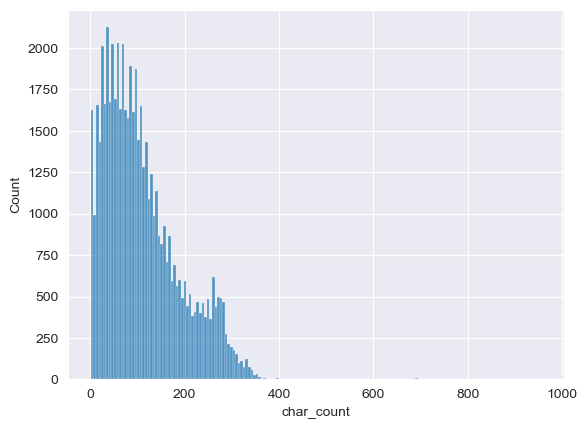

In [25]:
sns.histplot(df["char_count"])

<Axes: >

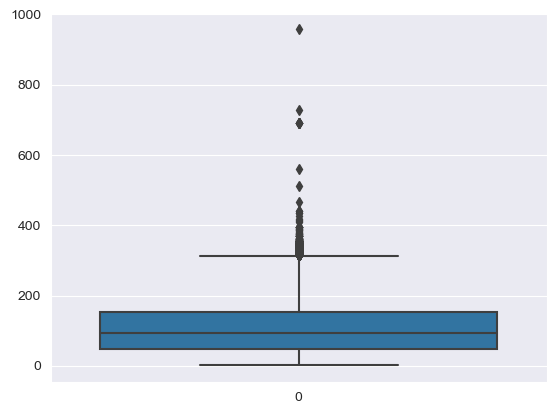

In [26]:
sns.boxplot(df["char_count"])

In [27]:
df["word_count"].describe()

count    57626.000000
mean        19.442699
std         14.416694
min          0.000000
25%          8.000000
50%         16.000000
75%         28.000000
max        198.000000
Name: word_count, dtype: float64

<Axes: xlabel='word_count', ylabel='Count'>

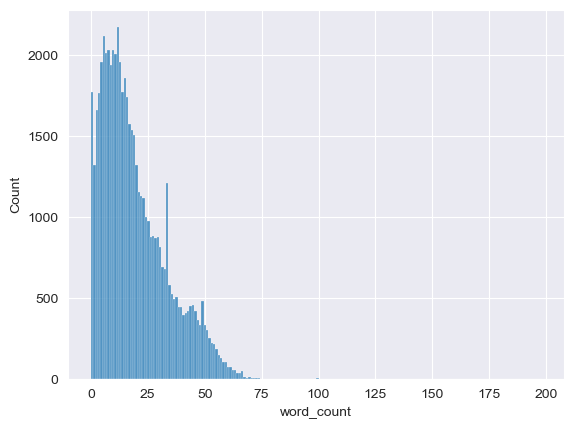

In [28]:
sns.histplot(df["word_count"])

<Axes: >

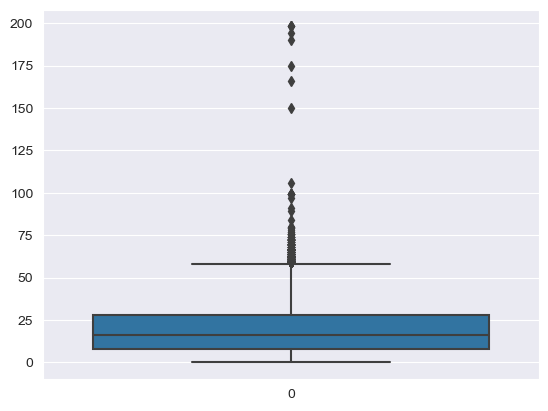

In [29]:
sns.boxplot(data=df["word_count"])

In [30]:
# Ausreißer auf numerische Art bestimmen: 3 Standardabweichungen vom Mittelwert entfernt = Ausreißer
def find_outlier(data):
    for num_col in data.select_dtypes(["number"]).columns:
        sd = data[num_col].std()
        mean = data[num_col].mean()
        result = [out for out in data[num_col] if (out > mean + 3 * sd) or (out < mean - 3 * sd)]
        print()
        print("Column: ", num_col)
        print("Mean: ", mean, "; Std: ", sd)
        print("Outlier: ", len(result), "; Values: ", sorted(result))

In [31]:
find_outlier(df[["char_count", "word_count"]])


Column:  char_count
Mean:  109.9277930100996 ; Std:  79.34543063760277
Outlier:  117 ; Values:  [348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 352, 352, 353, 353, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356, 356, 357, 357, 358, 358, 358, 359, 359, 360, 360, 361, 361, 361, 362, 362, 363, 365, 365, 368, 368, 369, 369, 369, 370, 370, 370, 371, 371, 374, 375, 376, 377, 377, 382, 385, 386, 386, 388, 388, 392, 394, 395, 395, 395, 395, 396, 396, 408, 411, 415, 418, 427, 434, 435, 441, 441, 467, 513, 559, 692, 692, 692, 692, 692, 692, 727, 957]

Column:  word_count
Mean:  19.442699475931004 ; Std:  14.416693922829971
Outlier:  281 ; Values:  [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6

In [32]:
df[df["char_count"] >= 349]

,thread,topic,sentiment,tweet,char_count,word_count
113,8834,Nvidia,Neutral,New GMiner 2. 05 upgrade With Further Improved...,356,61
1323,4805,GrandTheftAuto(GTA),Irrelevant,Once COVID - 19 came to the full GTA and lockd...,360,61
4445,10556,RedDeadRedemption(RDR),Neutral,There was a meeting with the interns on their ...,513,190
4881,12966,Xbox(Xseries),Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",692,99
4907,11893,Verizon,Neutral,wow this is also groundbreaking : “ under the ...,354,62
...,...,...,...,...,...,...
54540,1120,AssassinsCreed,Negative,"Finally, Kingdom Come:. Deliverance... The per...",559,52
54981,4725,Google,Neutral,"This is not law, not its full history, a more ...",351,55
55381,3580,Facebook,Neutral,Sorry for the incredible tech difficulties bac...,370,62
55821,7173,johnson&johnson,Neutral,A massive lawsuit against Johnson & Johnson wi...,358,59


In [33]:
df[df["word_count"] >= 63]

,thread,topic,sentiment,tweet,char_count,word_count
529,9097,Nvidia,Neutral,Nvidia RTX series 3080 cards here are selling ...,329,63
867,8413,NBA2K,Negative,"to keep it a bean, the shooting is a huge prob...",338,68
1078,8711,NBA2K,Negative,@Ronnie2K please @NBA2K @2KSupport help me Iv ...,336,80
1391,8373,Microsoft,Neutral,"I may so not be the first to observe of this, ...",330,68
1587,9276,Overwatch,Negative,i haven'e t been able actually to seriously wr...,345,67
...,...,...,...,...,...,...
56422,10460,RedDeadRedemption(RDR),Positive,@RockstarGames I ’ m not asking for any additi...,305,63
56628,10938,TomClancysGhostRecon,Positive,Now that the AI - team mates are back in with ...,333,67
57073,4008,CS-GO,Negative,There was a major point in csgo where i desper...,340,67
57267,7601,MaddenNFL,Negative,Bro fuck madden 21 guys why now does the game ...,306,64


=> Strategie: Einträge droppen, um ML Modelle nicht durch Ausreißer zu beeinflussen (bei DeepLearning-Modellen tendenziell irrelevant)

In [34]:
df = df[df["char_count"] < 349]
df[df["char_count"] >= 349]

,thread,topic,sentiment,tweet,char_count,word_count


In [35]:
df = df[df["word_count"] < 63]
df[df["word_count"] >= 63]

,thread,topic,sentiment,tweet,char_count,word_count


In [36]:
# df.drop(['Char_Count', 'Word_Count'], axis=1, inplace=True)

## Datensatz nach Bereinigung

In [37]:
print(df.count())
print(df_raw.count())
print(df.count() - df_raw.count())
print(df.count() / df_raw.count() - 1)

thread        57286
topic         57286
sentiment     57286
tweet         57286
char_count    57286
word_count    57286
dtype: int64
thread       74682
topic        74682
sentiment    74682
tweet        73996
dtype: int64
char_count        NaN
sentiment    -17396.0
thread       -17396.0
topic        -17396.0
tweet        -16710.0
word_count        NaN
dtype: float64
char_count         NaN
sentiment    -0.232934
thread       -0.232934
topic        -0.232934
tweet        -0.225823
word_count         NaN
dtype: float64


## Check Val/Test-Data

In [38]:
# df_val_raw = pd.read_csv("C:\\Users\\admin\\PycharmProjects\\WebScience24\\data\\twitter_hate-speech\\twitter_validation.csv", index_col=0) # Fehlerhaft

=> Bewertung Validation-Daten: sehr viele Fehler, ohne händisches Säubern ggf. nicht verwendbar, von der Menge her gering (> 2000)



## Save cleaned Data

In [39]:
filepath = Path('data/twitter_training_cleaned.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [40]:
df.to_csv(filepath)

# EDA

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57286 entries, 0 to 57625
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   thread      57286 non-null  int64 
 1   topic       57286 non-null  object
 2   sentiment   57286 non-null  object
 3   tweet       57286 non-null  object
 4   char_count  57286 non-null  int64 
 5   word_count  57286 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [42]:
df.describe()

,thread,char_count,word_count
count,57286.000000,57286.000000,57286.000000
mean,6435.678490,108.501484,19.156722
std,3735.604654,77.208325,13.872167
min,1.000000,1.000000,0.000000
25%,3207.250000,48.000000,8.000000
50%,6439.000000,91.000000,16.000000
75%,9581.750000,153.000000,27.000000
max,13200.000000,348.000000,62.000000


## Korrelationsanalyse

In [43]:
df["sentiment_binary"] = df["sentiment"] == "Negative"

<Axes: >

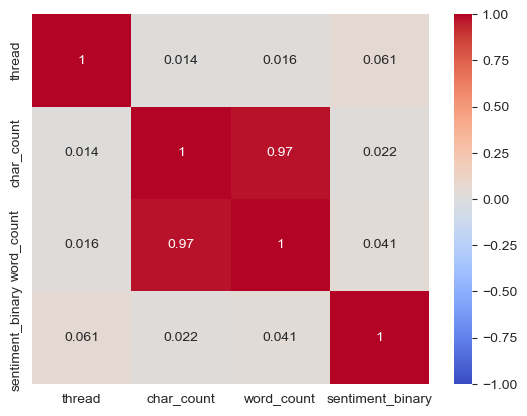

In [44]:
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap="coolwarm")

In [45]:
target_corr = df.corr(numeric_only=True)["sentiment_binary"]
target_corr.abs().sort_values(ascending=False)

sentiment_binary    1.000000
thread              0.060522
word_count          0.040545
char_count          0.021963
Name: sentiment_binary, dtype: float64

Korrelationsanalyse feature<->target => keine originären numerischen Werte, bei den erzeugten numerischen Werten keine nennenswerte Korrelation erkennbar

## Targetanalyse

In [46]:
df["sentiment"].value_counts()

Negative      17297
Positive      15874
Neutral       14045
Irrelevant    10070
Name: sentiment, dtype: int64

<Axes: ylabel='sentiment'>

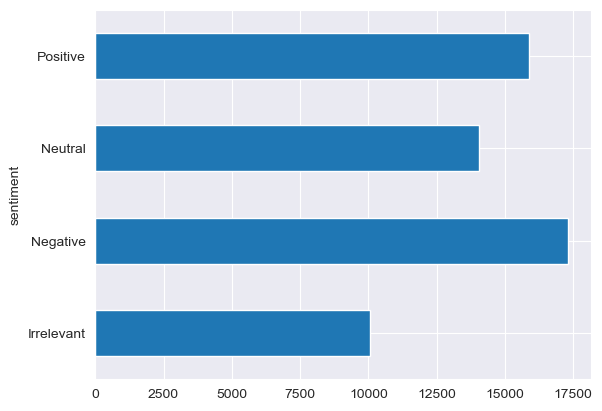

In [47]:
(df.groupby(["sentiment"])
 .size()
 .plot
 .barh())

## Featureanalyse

<Axes: xlabel='topic', ylabel='Count'>

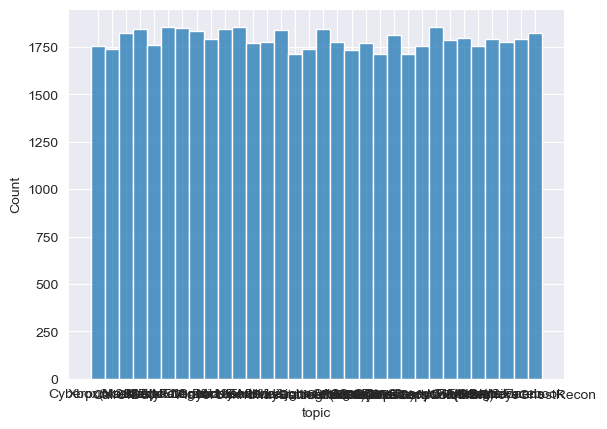

In [48]:
# Feature: Topic
sns.histplot(
    df["topic"])  # Topics sind (grob) gleichverteilt, ggf. ein Ausreißer falls beide COD-Topics zusammengelegt werden

<Axes: xlabel='word_count', ylabel='Count'>

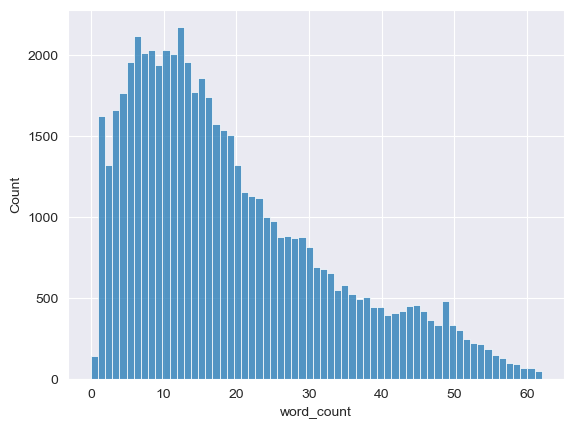

In [49]:
# Feature: Tweet
sns.histplot(df["word_count"])

<Axes: xlabel='char_count', ylabel='Count'>

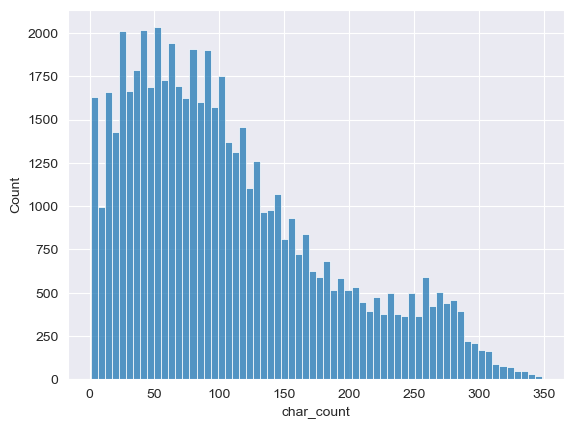

In [50]:
sns.histplot(df["char_count"])

## Feature x Target

Text(0.5, 1.0, 'Irrelevant Tweets')

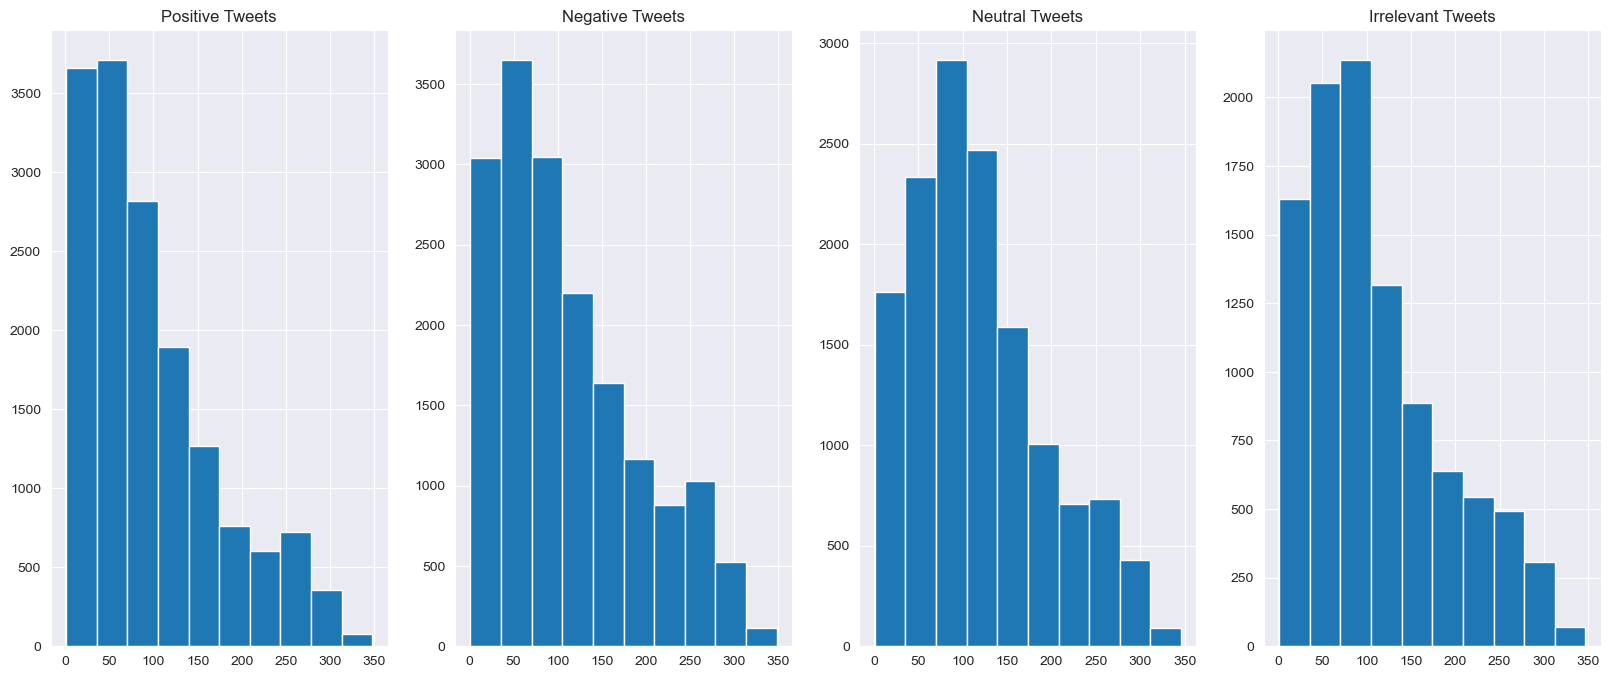

In [51]:
# Char_Count
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.hist(df[df['sentiment'] == 'Positive']['char_count'])
ax1.set_title('Positive Tweets')
ax2.hist(df[df['sentiment'] == 'Negative']['char_count'])
ax2.set_title('Negative Tweets')
ax3.hist(df[df['sentiment'] == 'Neutral']['char_count'])
ax3.set_title('Neutral Tweets')
ax4.hist(df[df['sentiment'] == 'Irrelevant']['char_count'])
ax4.set_title('Irrelevant Tweets')

Text(0.5, 1.0, 'Irrelevant Tweets')

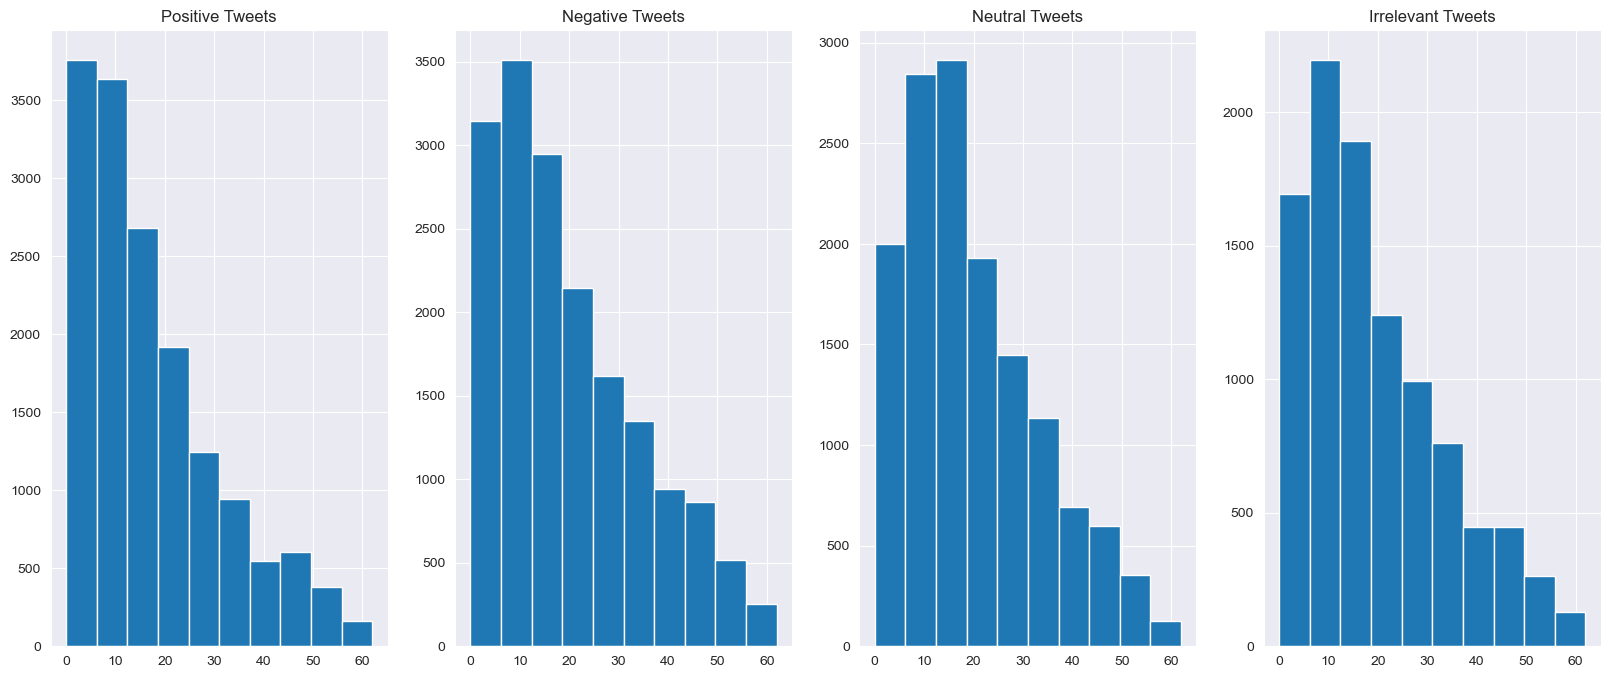

In [52]:
# Char_Count
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.hist(df[df['sentiment'] == 'Positive']['word_count'])
ax1.set_title('Positive Tweets')
ax2.hist(df[df['sentiment'] == 'Negative']['word_count'])
ax2.set_title('Negative Tweets')
ax3.hist(df[df['sentiment'] == 'Neutral']['word_count'])
ax3.set_title('Neutral Tweets')
ax4.hist(df[df['sentiment'] == 'Irrelevant']['word_count'])
ax4.set_title('Irrelevant Tweets')

# Data Preprocessing for Naive-Bayes

## Text cleaning: emojis, toLower etc.

In [53]:
def cleaning(text):
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()  # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text)  # removing URL links
    text = re.sub(r"\b\d+\b", "", text)  # removing number
    text = re.sub('<.*?>+', '', text)  # removing special characters,
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)

    #removing emoji:
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # removing short form:
    text = re.sub("isn't", 'is not', text)
    text = re.sub("he's", 'he is', text)
    text = re.sub("wasn't", 'was not', text)
    text = re.sub("there's", 'there is', text)
    text = re.sub("couldn't", 'could not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("they're", 'they are', text)
    text = re.sub("she's", 'she is', text)
    text = re.sub("There's", 'there is', text)
    text = re.sub("wouldn't", 'would not', text)
    text = re.sub("haven't", 'have not', text)
    text = re.sub("That's", 'That is', text)
    text = re.sub("you've", 'you have', text)
    text = re.sub("He's", 'He is', text)
    text = re.sub("what's", 'what is', text)
    text = re.sub("weren't", 'were not', text)
    text = re.sub("we're", 'we are', text)
    text = re.sub("hasn't", 'has not', text)
    text = re.sub("you'd", 'you would', text)
    text = re.sub("shouldn't", 'should not', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("they've", 'they have', text)
    text = re.sub("You'll", 'You will', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub("we've", 'we have', text)
    text = re.sub("it's", 'it is', text)
    text = re.sub("don't", 'do not', text)
    text = re.sub("that´s", 'that is', text)
    text = re.sub("I´m", 'I am', text)
    text = re.sub("it’s", 'it is', text)
    text = re.sub("she´s", 'she is', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('I’m', 'I am', text)
    text = re.sub('I’d', 'I did', text)
    text = re.sub("he’s'", 'he is', text)
    text = re.sub('there’s', 'there is', text)

    return text

In [54]:
dt = df['tweet'].apply(cleaning)

In [55]:
dt = pd.DataFrame(dt)
dt['sentiment'] = df['sentiment']

In [56]:
dt.head()

,tweet,sentiment
0,booo,Negative
1,ok hear me out microsoft is going to pull a mi...,Neutral
2,hopping on the uzi is pretty good fortunate...,Positive
3,mr christoph sandrock best pubg teammate rescu...,Positive
4,eamaddennfl what is up with these player ratin...,Negative


## Stopwords

In [57]:
dt['no_sw'] = dt['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [58]:
dt.head(20)

,tweet,sentiment,no_sw
0,booo,Negative,booo
1,ok hear me out microsoft is going to pull a mi...,Neutral,hear microsoft pull mix ass prove choose xbox ...
2,hopping on the uzi is pretty good fortunate...,Positive,hopping uzi pretty fortunate time twitchtvjoke65
3,mr christoph sandrock best pubg teammate rescu...,Positive,mr christoph sandrock pubg teammate rescuer cr...
4,eamaddennfl what is up with these player ratin...,Negative,eamaddennfl player ratings algorithm wrong
5,im very pleased to see everyone playing cyberp...,Positive,pleased playing cyberpunk completely missing o...
6,a ban for battlefield player itzawwzy has occ...,Irrelevant,ban battlefield player itzawwzy occurred detai...
7,be soon into the warcraft official release m ...,Positive,warcraft official release newsblizzardcomenusw...
8,we need about a third for ranked right around now,Neutral,ranked
9,is,Negative,


## Most frequent words

In [59]:
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(20)
temp = pd.DataFrame(cnt.most_common(20))
temp.columns = ['word', 'count']

In [60]:
temp.head(20)

,word,count
0,game,6275
1,play,2649
2,love,2498
3,time,2280
4,johnson,2271
5,shit,2102
6,games,1759
7,great,1738
8,playing,1665
9,xbox,1632


most frequent words erstmal nicht entfernen (love, shit etc. vmtl. ausschlaggebend für Klassifikation)

In [61]:
# FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
# def remove_freqwords(text):
#     return " ".join([word for word in str(text).split() if word not in FREQWORDS])
# dt["no_sw_no_freqwo"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))

In [62]:
# dt.head()

In [63]:
# dt[dt.no_sw != dt.no_sw_no_freqwo].head()

## Lemmatization

In [64]:
wordnet_lem = WordNetLemmatizer()
dt['no_sw_lem'] = dt['no_sw'].apply(wordnet_lem.lemmatize)

In [65]:
dt.head()

,tweet,sentiment,no_sw,no_sw_lem
0,booo,Negative,booo,booo
1,ok hear me out microsoft is going to pull a mi...,Neutral,hear microsoft pull mix ass prove choose xbox ...,hear microsoft pull mix ass prove choose xbox ...
2,hopping on the uzi is pretty good fortunate...,Positive,hopping uzi pretty fortunate time twitchtvjoke65,hopping uzi pretty fortunate time twitchtvjoke65
3,mr christoph sandrock best pubg teammate rescu...,Positive,mr christoph sandrock pubg teammate rescuer cr...,mr christoph sandrock pubg teammate rescuer cr...
4,eamaddennfl what is up with these player ratin...,Negative,eamaddennfl player ratings algorithm wrong,eamaddennfl player ratings algorithm wrong


In [66]:
dt[dt.no_sw != dt.no_sw_lem].head(500)

,tweet,sentiment,no_sw,no_sw_lem
79,the best uniforms,Positive,uniforms,uniform
222,all comments,Irrelevant,comments,comment
276,last one sounds way too good to be said true,Positive,sounds,sound
1521,lies,Negative,lies,lie
3011,mistakes,Irrelevant,mistakes,mistake
...,...,...,...,...
56977,feels the good man,Positive,feels,feel
57446,hotdogs ever,Positive,hotdogs,hotdog
57471,old days,Irrelevant,days,day
57501,the works for me,Positive,works,work


## Check again: Duplicates / NaN

In [67]:
dt.duplicated().sum()

2135

In [68]:
dt.drop_duplicates(inplace=True)
dt.duplicated().sum()

0

In [72]:
dt.isna().sum()

tweet        0
sentiment    0
no_sw        0
no_sw_lem    0
dtype: int64

In [69]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55151 entries, 0 to 57624
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      55151 non-null  object
 1   sentiment  55151 non-null  object
 2   no_sw      55151 non-null  object
 3   no_sw_lem  55151 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


## Save preprocessed data

In [70]:
filepath = Path('data/twitter_training_cleaned_preprocessed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

In [71]:
dt.to_csv(filepath)